# Calcul du Gradient
L'objectif de ce _notebook_ est définir le calcul du gradient pour un réseau donné (ici appelé MiniNetA).

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [2]:
def create_mini_net_A():
    A = np.matrix([[0, 1/3., 1/3., 1/3.],
                   [0, 0, 1/2., 1/2.],
                   [1, 0, 0, 0],
                   [1/2., 0, 1/2., 0]]).transpose()
    return A

def calculateM(A, alpha):
    M = (1 - alpha) * A
    S = np.ones((M.shape[0], M.shape[0]))
    S = (alpha / M.shape[0]) * S
    M = M + S
    return M

Dans le travail préparatoire, on a vérifié qui la valeur de _beta_ doit attendre le consigne: 4 + _gamma_ * n.

In [3]:
def get_constants(A, gamma):
    beta = 4 + A.shape[0] * gamma
    mu = 1.99 / beta
    return beta, mu

In [4]:
A = create_mini_net_A()
M = calculateM(A, 0.15) #alpha = 0.15
frame = pd.DataFrame(M)
frame

,0,1,2,3
0,0.037500,0.0375,0.8875,0.4625
1,0.320833,0.0375,0.0375,0.0375
2,0.320833,0.4625,0.0375,0.4625
3,0.320833,0.4625,0.0375,0.0375


Ci-dessous, le code pour sélectionner la valeur de _gamma_. Pour changer la valeur (de 1/n² à 1/n) il faut changer l'argument de __get_gamma__ à __False__.

In [5]:
def get_gamma(n_sqrd, size):
    if(n_sqrd):
        return float (1) / size * size #gamma = 1 / n²
    return float (1) / size            #gamma = 1 / n

gamma = get_gamma(False, M.shape[0])   #False = 1 / n || True = 1 / n²
beta, mu = get_constants(A, gamma)

La fonction ci-dessous pour l'obtention du vecteur optimal a été basée sur une méthode d'un collègue.
La fonction __get_random_x__ génère un vecteur randomique pour être le x(0) de l'algorithme.

In [6]:
def get_score_vector(M):
    v, w = np.linalg.eig(M)
    v = np.real(v)
    (m,) = np.shape(v)
    for i in range(m):
        if abs(v[i]-1) < 1e-3:
            vi = w[:, i]
    vi = np.real(vi)
    vi = vi/np.linalg.norm(vi, 1)
    vi = np.round(vi, 3)
    return(vi)

def get_random_x(size):
    return np.matrix(np.random.randint(size-1, size=size).reshape((size, 1)))

Ci-dessous, les fonctions pour le calcul de l'hessienne, du gradient et de la fonction principale.

In [7]:
def Hessian(M, gamma):
    I = np.identity(M.shape[0])
    e_square = np.ones((M.shape[0], M.shape[0]))
    return np.transpose(M - I) * (M - I) + gamma * e_square

def DF(x, M, gamma):
    e = np.ones((M.shape[0], 1))
    return Hessian(M, gamma) * x - gamma * e

def F(x, M, gamma):
    ''' inner_x = 1/2 ||Mx - x||
        inner_y = gamma/2 (sum(x) -1)^2'''
    inner_X = 0.5 * np.linalg.norm( M * x - x )
    inner_Y = gamma * 0.5 * (np.sum(x) - 1) ** 2
    return inner_X + inner_Y, 5

In [8]:
x_etoile = get_score_vector(M)
x_current = get_random_x(M.shape[0])

Les listes suivantes sertent à :
* points : contient les modules || x(k) - x* ||
* logs : contient les log( 1 + || x(k) - x* || )
* fs : valeurs de la fonction dans le point x(k)

In [9]:
points = []
logs = []
fs = []
iterations = 20

Le boucle principal est composé seulement par l'_update_ de x_current ( x(k+1) ).

In [10]:
for i in range(iterations):
    x_current = x_current - mu * DF(x_current, M, gamma)
    
    points.append(np.linalg.norm(x_current - x_etoile))
    logs.append(np.log(1 + np.linalg.norm(x_current - x_etoile)))
    fs.append(F(x_current, M, gamma))

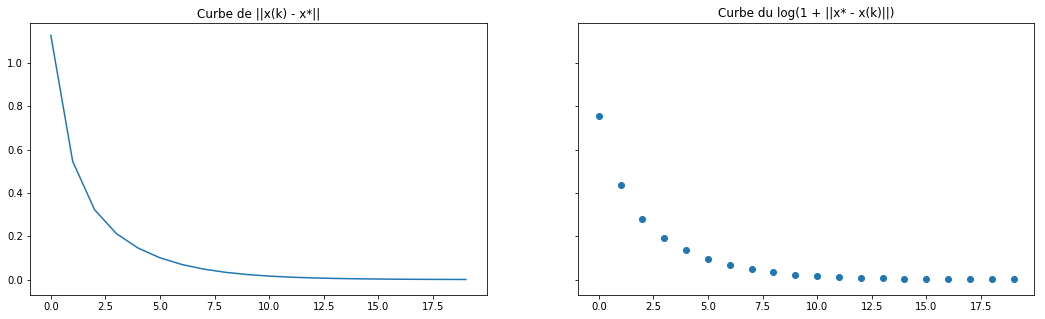

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18, 5))
x = [x for x in range(0, iterations)]
ax1.plot(x, points)
ax1.set_title('Curbe de ||x(k) - x*||')
ax2.scatter(x, logs)
ax2.set_title('Curbe du log(1 + ||x* - x(k)||)')
plt.show()

### Question 1 -- Résultats obtenus
Les plots ci-dessus montrent que en fait la curbe de mis-à-jour est très similaire à la courbe du logarithme du module. En observant la courbe de la fonction, on peut remarquer que la convergence est atteinte tôt car le point optimale était déjà proche au vecteur de début (randomique).

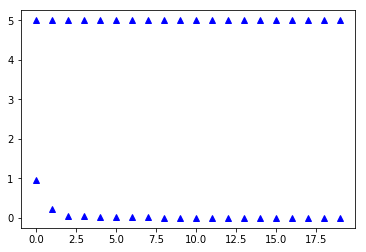

In [12]:
plt.plot([x for x in range(0, iterations)], fs, 'b^')
plt.show()

### Question 2 -- Comparaison de la vitesse
Pour évaluer la vitesse, il faut calculer les eigenvalues de la matrice AA(-1). D'accord le TD2, la taux de convergence optimale est donnée par 2 * ( _lambda_(n) - 1) / (_lambda_(1) + _lambda_(n)).
La fonction ci-dessous renvoie la valeur de _lambda_(1), _lambda_(n).

In [13]:
def get_lambdas(A, mu):
    I = np.identity(A.shape[0])
    matrix = I - mu * np.transpose(A) * A
    lambdas = np.linalg.eig(matrix)
    return lambdas[0][0], lambdas[0][-1]
lambda1, lambdan = get_lambdas(A, mu)
print("Vitesse théorique: " + str(2 * (lambdan - 1) / ( lambda1 - lambdan )))

Vitesse théorique: 0.16336182515708017


Ici, on compare la vittesse théorique et la moyenne entre les différences observées. On voit que pour _gamma_ = 1 / n² la vitesse moyenne est inférieure à la moyenne. Par contre, avec _gamma_ = 1 / n, la baisse de la courbe est plus fort, et la vitesse, plus haute.

In [14]:
moyenne = sum(points) / len(points)
print("Vitesse moyenne: " + str(moyenne))

Vitesse moyenne: 0.13411237125769987


### Question 3 -- Complexité à chaque itération
La complexité de chaque itération est à cause de la transposition des matrices ( O(n) ) et multiplications ( O(n³) ). Donc, la complexité de la ligne de mis à jour est, au pire, O(2n³).

### Question 4 -- Comment accelerer
On peut utiliser la valeur auxiliaire y(k), qui ajoute un facteur de "inertia" au algorithme. Donc, le pas de chaque itération est plus grand, aussi comme le temps de stabilisation. On peut voir l'oscilation du résultat Dans les figures ci-dessous.
La complexité du nouveau algorithme est presque la même: une seule subtraction entre vecteurs était ajouté, avec complexité O(n).

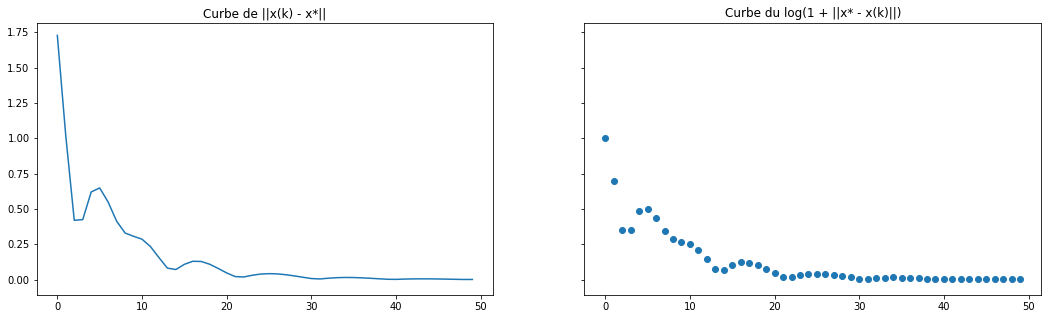

In [24]:
points = []
logs = []
x_current = get_random_x(M.shape[0])
x_ancient = x_current
iterations = 50

for i in range(iterations):
    y_current = x_current + (1 - gamma * mu) * (x_current - x_ancient)
    x_ancient = x_current
    x_current = y_current - mu * mu * DF(y_current, M, gamma)

    points.append(np.linalg.norm(x_current - x_etoile))
    logs.append(np.log(1 + np.linalg.norm(x_current - x_etoile)))
    
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18, 5))
x = [x for x in range(0, iterations)]
ax1.plot(x, points)
ax1.set_title('Curbe de ||x(k) - x*||')
ax2.scatter(x, logs)
ax2.set_title('Curbe du log(1 + ||x* - x(k)||)')
plt.show()

### Question 5 -- Usage de la fonction _sparse_
Une fonctionnalité dans le module __scipy__ est la création de matrices sparses. Le résultat de l'usage d'une matrice sparse du type _csr_ (Compressed Sparse Row) est une courbe plus douce.

In [25]:
S = csr_matrix(A)
M = calculateM(S, 0.15) #alpha = 0.15
frame = pd.DataFrame(M)
frame

,0,1,2,3
0,0.037500,0.0375,0.8875,0.4625
1,0.320833,0.0375,0.0375,0.0375
2,0.320833,0.4625,0.0375,0.4625
3,0.320833,0.4625,0.0375,0.0375


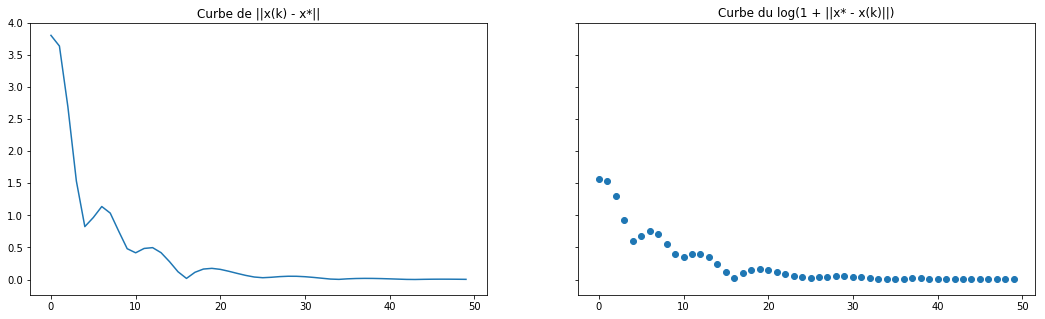

In [26]:
x_etoile = get_score_vector(M)
x_current = get_random_x(M.shape[0])

points = []
logs = []
fs = []
iterations = 50

for i in range(iterations):
    y_current = x_current + (1 - gamma * mu) * (x_current - x_ancient)
    x_ancient = x_current
    x_current = y_current - mu * mu * DF(y_current, M, gamma)

    points.append(np.linalg.norm(x_current - x_etoile))
    logs.append(np.log(1 + np.linalg.norm(x_current - x_etoile)))
    
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18, 5))
x = [x for x in range(0, iterations)]
ax1.plot(x, points)
ax1.set_title('Curbe de ||x(k) - x*||')
ax2.scatter(x, logs)
ax2.set_title('Curbe du log(1 + ||x* - x(k)||)')
plt.show()